In [28]:
!pip install torch
!pip install kmeans-pytorch

In [29]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/advanced_ml_final_project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np

embeddings = pd.read_pickle('/content/drive/MyDrive/advanced_ml_final_project/other_data/clean_2020articles_w_title_embeddings.pkl')

In [31]:
embeddings.rename(columns={"bert_sentence_embedding_title_only": "bert_embeddings"})
embeddings["bert_embeddings"] = embeddings["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
embeddings["np_embeddings"] = embeddings["bert_embeddings"].apply(lambda x: x.numpy())

In [32]:
np_embeddings = np.vstack(embeddings["np_embeddings"])

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score # TODO read about these scoring mechanisms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)

    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(embeddings["target"], y_pred)
    nmi = normalized_mutual_info_score(embeddings["target"], y_pred)
    fmi = fowlkes_mallows_score(embeddings["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    embeddings[f'x0_{method}'] = x0
    embeddings[f'x1_{method}'] = x1

def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"Clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=embeddings, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


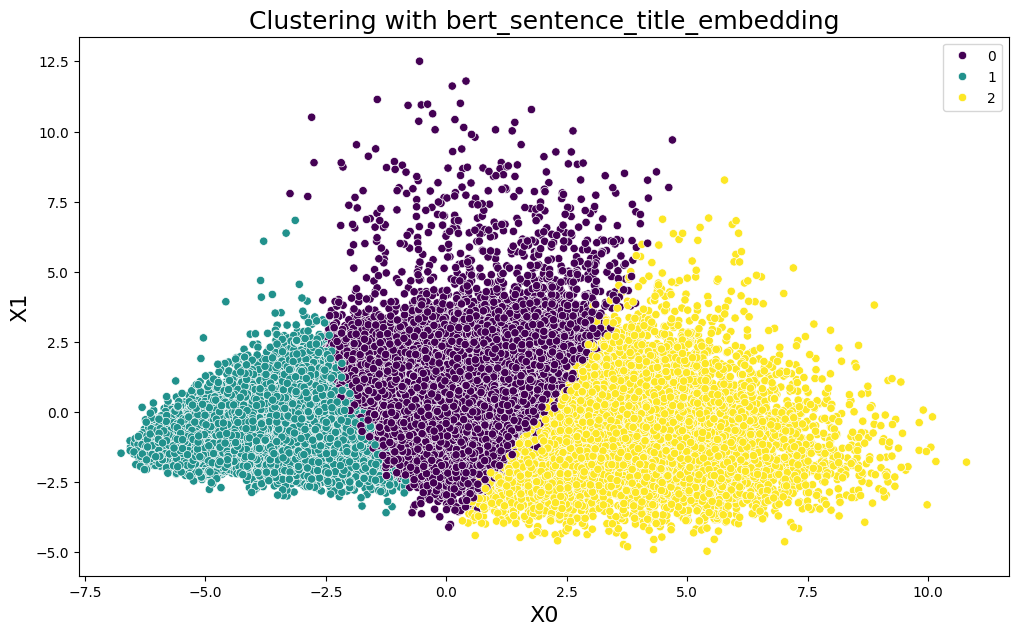

In [34]:
method = 'bert_sentence_title_embedding'
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)

# fit the model
kmeans.fit(np_embeddings)

# store cluster labels in a variable
clusters = kmeans.labels_

# Assign clusters to our dataframe
clusters_result_name = f'cluster_bert_embeddings'
embeddings['bert_clusters'] = clusters

#eval_cluster(np_embeddings)

dimension_reduction(np_embeddings, method)

plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters, method=method)

In [35]:
k_values = [10,50,100,200]
for k in k_values:
    print("Creating kmeans with {} clusters".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42,max_iter=1000)
    kmeans.fit(np_embeddings)
    clusters = kmeans.labels_
    embeddings[f'cluster_{k}'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
count_clusters_k10 = embeddings.groupby("cluster_10").count().sort_values(by="title", ascending=False)["title"]
count_clusters_k50 = embeddings.groupby("cluster_50").count().sort_values(by="title", ascending=False)["title"]
count_clusters_k100 = embeddings.groupby("cluster_100").count().sort_values(by="title", ascending=False)["title"]
count_clusters_k200 = embeddings.groupby("cluster_200").count().sort_values(by="title", ascending=False)["title"]

In [37]:
count_clusters_k10

cluster_10
8    7205
3    4959
1    4748
9    3867
4    3742
6    3378
5    3142
7    3038
0    2390
2     575
Name: title, dtype: int64

In [38]:
count_clusters_k50

cluster_50
3     2245
42    1812
2     1766
29    1406
19    1195
15    1109
10    1060
7     1018
45     956
21     891
43     867
26     861
14     841
27     817
32     811
23     810
40     808
1      795
28     780
46     770
11     761
44     741
0      731
22     720
37     716
33     658
13     637
12     631
41     627
9      622
36     607
8      552
17     550
6      548
35     543
48     529
4      517
39     470
49     459
16     452
18     448
5      429
38     420
24     411
31     395
30     328
25     281
20     262
47     253
34     128
Name: title, dtype: int64

In [39]:
count_clusters_k100

cluster_100
86    1358
25    1061
61     994
46     929
72     917
      ... 
83     160
97     154
74     122
0      114
20      93
Name: title, Length: 100, dtype: int64

In [40]:
doc_per_topic_k10 = embeddings.groupby("cluster_10",as_index=False).agg({"title": " ".join})
doc_per_topic_k50 = embeddings.groupby("cluster_50",as_index=False).agg({"title": " ".join})
doc_per_topic_k100 = embeddings.groupby("cluster_100",as_index=False).agg({"title": " ".join})
doc_per_topic_k200 = embeddings.groupby("cluster_200",as_index=False).agg({"title": " ".join})

In [41]:
doc_per_topic_k10

,cluster_10,title
0,0,"trump slams relief bill, calls on congress to ..."
1,1,‘zuck bucks 2.0’: liberal group uses legal ‘ma...
2,2,trump says he wanted to assassinate syrian pre...
3,3,blue state ag backs down from targeting religi...
4,4,covid select subcommittee subpoenas co-author ...
5,5,west virginia gov. jim justice endorses trump ...
6,6,us forces rescue american citizen held hostage...
7,7,court sides with catholic school that let empl...
8,8,"trump shifts tone, says he’s ‘proud’ of fed am..."
9,9,"iran paid bounties for targeting us troops, in..."


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count



In [43]:
def extract_top_n_words_per_topic(tf_idf, count, doc_per_topic,k_cluster, n=20):
    words = count.get_feature_names_out()
    labels = list(doc_per_topic[k_cluster])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [44]:
tf_idf_10, count_10 = c_tf_idf(doc_per_topic_k10["title"], m=len(embeddings))
top_n_words_10 = extract_top_n_words_per_topic(tf_idf_10, count_10, doc_per_topic_k10,"cluster_10", n=20)
top_n_words_10

{0: [('coronavirus', 0.04953153006788495),
  ('trump', 0.03757515670555586),
  ('gov', 0.029872855097634668),
  ('house', 0.025822893448345523),
  ('new', 0.023582556203295614),
  ('passes', 0.02011332028072594),
  ('governor', 0.0188834736234579),
  ('announces', 0.01847990962300899),
  ('signs', 0.018334061883929362),
  ('donald', 0.017676740956113993),
  ('state', 0.017389260364332068),
  ('senate', 0.01630820759205579),
  ('court', 0.016192829110866287),
  ('police', 0.015960531230674348),
  ('000', 0.015402697022793725),
  ('order', 0.015016896711358647),
  ('relief', 0.014703056921620486),
  ('ban', 0.014412745893433741),
  ('biden', 0.014288243784260904),
  ('supreme', 0.013259488110416398)],
 1: [('biden', 0.04159081728619709),
  ('trump', 0.038474014858695886),
  ('joe', 0.020961333682060185),
  ('gop', 0.019873727686559862),
  ('coronavirus', 0.019135364520848762),
  ('says', 0.01766727193108292),
  ('pelosi', 0.016765413601534995),
  ('rep', 0.016609605770580183),
  ('people

In [45]:
tf_idf_50, count_50 = c_tf_idf(doc_per_topic_k50["title"], m=len(embeddings))
top_n_words_50 = extract_top_n_words_per_topic(tf_idf_50, count_50, doc_per_topic_k50,"cluster_50", n=20)
top_n_words_50[3]

[('trump', 0.037233794033445566),
 ('biden', 0.03559249175324164),
 ('joe', 0.021146976531286773),
 ('says', 0.018450579247830005),
 ('pelosi', 0.016534744608103273),
 ('don', 0.01559396902893228),
 ('cnn', 0.015050412320257153),
 ('coronavirus', 0.015008563502656532),
 ('donald', 0.013199042342176176),
 ('hunter', 0.012906476619389488),
 ('black', 0.012674739770079919),
 ('watch', 0.012593030555113592),
 ('america', 0.012033700322273919),
 ('barrett', 0.011666809477052602),
 ('democrats', 0.01141635284878548),
 ('election', 0.011086902183536378),
 ('exclusive', 0.011048080770079884),
 ('amy', 0.010882963795478566),
 ('carlson', 0.010767844576564064),
 ('mike', 0.010687641207630202)]

In [46]:
tf_idf_100, count_100 = c_tf_idf(doc_per_topic_k100["title"], m=len(embeddings))
top_n_words_100 = extract_top_n_words_per_topic(tf_idf_100, count_100, doc_per_topic_k100,"cluster_100", n=20)
print("1st cluster:",top_n_words_100[86][:10])
print("2nd cluster:",top_n_words_100[25][:10])
print("3rd cluster:",top_n_words_100[61][:10])
print("4th cluster:",top_n_words_100[46][:10])
print("5th cluster:",top_n_words_100[72][:10])

embeddings[embeddings.cluster_100==86]["title"]


1st cluster: [('biden', 0.03776697470978846), ('trump', 0.03497452086057714), ('joe', 0.02096713906762132), ('cnn', 0.0178824422978802), ('watch', 0.017117817258197228), ('don', 0.017007490807883278), ('pelosi', 0.01685164095875079), ('hunter', 0.016828891092143545), ('says', 0.016406687296445198), ('coronavirus', 0.01638121843738754)]
2nd cluster: [('says', 0.07308697048417133), ('trump', 0.06190322684934885), ('biden', 0.04498681804480169), ('claims', 0.02562626244981671), ('democrats', 0.02350197092216737), ('joe', 0.021473404775802195), ('calls', 0.021061537655641865), ('white', 0.01697264024641574), ('coronavirus', 0.015290206177457926), ('president', 0.01520591105600718)]
3rd cluster: [('trump', 0.03752068980819131), ('biden', 0.024889521648051662), ('exclusive', 0.021962674296281588), ('donald', 0.02125017287243231), ('joe', 0.01705761715017166), ('black', 0.01681967551120704), ('new', 0.016715364125078555), ('mayor', 0.01618384204251017), ('slams', 0.01585290482686823), ('elect

43       police investigating after ‘vax the jews’ proj...
66       ‘squad’ member rashida tlaib will give rebutta...
71       trump gloats that jeff zucker’s ‘stench’ is ‘f...
81       ‘a bad day for joe biden’: nikki haley kicks o...
131      ‘pathetic’: trump snaps at bill barr for calli...
                               ...                        
34159          rubio's leaving the door open to a 2024 run
34244    super tuesday could show just how blue texas i...
34445    norman vincent peale was a conservative hero k...
36032    'borat' sequel grabs a political news cycle — ...
36758     reflection on a 4th that seems far from glorious
Name: title, Length: 1358, dtype: object

In [47]:
import itertools
for row in embeddings[embeddings.cluster_100==86][:100].itertuples():
    print(row.title)

police investigating after ‘vax the jews’ projected onto florida building
‘squad’ member rashida tlaib will give rebuttal to biden’s sotu
trump gloats that jeff zucker’s ‘stench’ is ‘finally leaving’ cnn
‘a bad day for joe biden’: nikki haley kicks off midterm push with war college speech
‘pathetic’: trump snaps at bill barr for calling his election claims ‘bullshit’
‘wokeness is a problem’: james carville says democrats won’t admit that because they’ll be ‘clobbered or canceled’
‘adam schiff took the bait’: top russiagate investigator explains gop strategy behind the ‘nunes memo’
democratic senator calls for biden’s new ag to examine ‘fake’ kavanaugh investigation 
tucker 2024? here’s where carlson stacks up against the competition
‘alexandria ocasio smollett’ trends as critics punch holes in her dramatic cap hill story
fbi used ‘ghosts’ to track trump advisor carter page in 2016
biden accuser tara reade: ‘unspeakably hard’ to watch biden take office
stephen king tells kayleigh mcenan

In [48]:
tf_idf_200, count_200 = c_tf_idf(doc_per_topic_k200["title"], m=len(embeddings))
top_n_words_200 = extract_top_n_words_per_topic(tf_idf_200, count_200, doc_per_topic_k200,"cluster_200", n=20)

In [49]:
count_clusters_k200

cluster_200
9      871
151    837
34     698
107    615
133    586
      ... 
167     57
180     50
106     49
160     49
65      40
Name: title, Length: 200, dtype: int64

In [50]:
print(top_n_words_200[9])
print(top_n_words_200[151])
print(top_n_words_200[34])

for row in embeddings[embeddings.cluster_200==9][:10].itertuples():
    print(row.title)

[('trump', 0.04090596501019258), ('biden', 0.027803376411779768), ('democrats', 0.01994357983474501), ('donald', 0.019652391398865876), ('says', 0.01894134861665416), ('mayor', 0.018299565112012875), ('chicago', 0.017596094055100042), ('joe', 0.016830258829208623), ('new', 0.016525161648551195), ('lightfoot', 0.01633535299382737), ('black', 0.015589701484710169), ('campaign', 0.015357705952991064), ('shot', 0.01499363156703052), ('claims', 0.01432405143629044), ('house', 0.013547038751786346), ('amy', 0.013385849328514414), ('election', 0.01323561075648113), ('coney', 0.012795088845441874), ('cnn', 0.012745785377554981), ('coronavirus', 0.012710344750674344)]
[('biden', 0.04175882211266536), ('trump', 0.030251556016137632), ('joe', 0.025421553946069736), ('watch', 0.025327468797935578), ('don', 0.02414749355680817), ('hunter', 0.020918677804243436), ('cnn', 0.019827011957052852), ('pelosi', 0.01971248935092315), ('like', 0.01911893548097112), ('coronavirus', 0.01909009242522009), ('goi

In [ ]:
#####K-means